In [2]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
from tqdm import tqdm
from sklearn.decomposition import PCA
import numpy as np
import time, math, sys
from IPython.utils import io
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'

sys.path.insert(1, '/home/joeadamo/Research')
from DarkEmuPowerRSD import pkmu_hod
from CovNet import CovNet, CovaPT

In [3]:
# IMPORTANT: Make sure the parameters here are the same as when you trained the network in question!
N = 49500
N_test = int(N*0.1)
train_log = False
train_correlation = False
train_cholesky = False
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set-NG/"
#training_dir = "/home/jadamo/CovNet/Data/Training-Set/"
save_dir = "/home/joeadamo/Research/CovNet/Plots/"
#save_dir = "/home/jadamo//CovNet/Plots/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
#BOSS_dir = "/home/jadamo/CovNet/Data/BOSS-DR12/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"
#CovaPT_dir = "/home/jadamo/CovaPT/Example-Data/"
net_dir = "../Data/Non-Gaussian/"

k =np.loadtxt(CovaPT_dir+'k_Patchy.dat')

In [4]:
# Chi squared stuff
pgg = pkmu_hod()
params_fid = np.array([67.8,0.1190,0.02215,3.094,2.01,-0.47])
Pk_fid = CovaPT.Pk_gg(params_fid, pgg)
data_vector = np.concatenate([Pk_fid[0], Pk_fid[2]])

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator
Deleted outdated persistence file, no further action needed.


In [5]:
def gaussian_covariance(params, i, offset):
    """
    Loads the model vector and gaussian covariance from file if it exists, otherwise calculates it
    """
    idx = i + offset
    if exists(training_dir+"CovG-"+f'{idx:05d}'+".npz"):
        data = np.load(training_dir+"CovG-"+f'{idx:05d}'+".npz")
        np.testing.assert_equal(params, data["params"], err_msg="parameters from file mismatch!")
        return data["model"], data["C"]
    else:
        Pk_galaxy = CovaPT.Pk_gg(params, pgg)
        model_vector = np.concatenate([Pk_galaxy[0], Pk_galaxy[2]])
        C_G = CovaPT.get_gaussian_covariance(params, pgg, Pk_galaxy)
        np.savez(training_dir+"CovG-"+f'{idx:05d}'+".npz", params=params, model=model_vector, C=C_G)
        return model_vector, 

In [6]:
# load the trained network
#net = CovNet.Network_Full(6, 100*100)
net = CovNet.Network_VAE(train_cholesky).to(CovNet.try_gpu());       net.eval()
encoder = CovNet.Block_Encoder().to(CovNet.try_gpu()); encoder.eval()
decoder = CovNet.Block_Decoder(train_cholesky).to(CovNet.try_gpu()); decoder.eval()
net_2 = CovNet.Network_Features(6, 10).to(CovNet.try_gpu())
net.load_state_dict(torch.load(net_dir+'network-VAE.params'))
encoder.load_state_dict(net.Encoder.state_dict())
decoder.load_state_dict(net.Decoder.state_dict())
net_2.load_state_dict(torch.load(net_dir+'network-features.params'))

<All keys matched successfully>

In [7]:
# load the test set
t1 = time.time()
test_data = CovNet.MatrixDataset(training_dir, N_test, int(N*0.9), train_log, train_correlation, train_cholesky)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 1.95 s


In [8]:
# get the L1 loss for the matrix -> latent -> matrix and params -> latent -> matrix pipelines
loss_data_1 = np.zeros(N_test)
loss_data_2 = np.zeros(N_test)
net.eval()
for i in tqdm(range(N_test)):
    params = test_data[i][0]; C_actual = CovNet.symmetric_log(test_data[i][1])
    C_reconstruct, mu, log_var = net(C_actual.view(1, 100, 100))
    C_predict = decoder(net_2(params).view(1,10)).view(100,100)
    
    C_actual = CovNet.symmetric_exp(C_actual)
    C_reconstruct = CovNet.symmetric_exp(C_reconstruct).view(100,100)
    C_predict = CovNet.symmetric_exp(C_predict)
    
    loss_data_1[i] = F.l1_loss(C_reconstruct, C_actual, reduction="sum")
    loss_data_2[i] = F.l1_loss(C_predict, C_actual, reduction="sum")
    
print("min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data_1), np.amax(loss_data_1), np.mean(loss_data_1)))
print("min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data_2), np.amax(loss_data_2), np.mean(loss_data_2)))

100%|██████████████████████████████████████| 4950/4950 [00:38<00:00, 128.74it/s]

min loss: 639732.188, max loss 9634586624.000, avg loss: 27263119.141
min loss: 1375941.875, max loss 1213178368.000, avg loss: 46370770.581


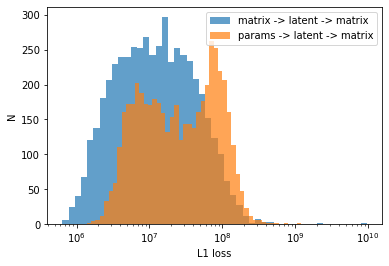

In [9]:
plt.hist(loss_data_1, alpha=0.7, label="matrix -> latent -> matrix", bins=np.logspace(np.log10(np.amin(loss_data_1)), np.log10(np.amax(loss_data_1)), 50))
plt.hist(loss_data_2, alpha=0.7, label="params -> latent -> matrix", bins=np.logspace(np.log10(np.amin(loss_data_2)), np.log10(np.amax(loss_data_2)), 50))
#plt.xlabel(r"$|\chi_{predict}^2 - \chi_{actual}^2|$")
plt.xlabel("L1 loss")
plt.ylabel("N")
plt.legend()
plt.xscale("log")

In [10]:
# get the chi squared differences using this network
# This cell takes ~ 1 hour to run
chi_squared_err = np.zeros(N_test)
chi_squared_actual = np.zeros(N_test)
non_definete = []; avg_bad = 0
for i in tqdm(range(N_test)):
    params = test_data[i][0]; C_NG_actual = test_data[i][1]
    features = net_2(params); C_NG_predict = decoder(features.view(1,10))
    #C_NG_actual = CovNet.symmetric_exp(C_NG_actual)
    C_NG_predict = CovNet.symmetric_exp(C_NG_predict)
    
    with io.capture_output() as captured:
        model_vector, C_G = gaussian_covariance(params.detach().numpy(), i, int(N*0.9))
    C_actual = C_G + C_NG_actual.view(100,100).detach().numpy()
    C_predict = C_G + C_NG_predict.view(100,100).detach().numpy()
    
    P_actual = np.linalg.inv(C_actual)
    P_predict = np.linalg.inv(C_predict)
    
    # if train_cholesky or train_correlation:
    #     if train_cholesky:
    #         prediction = torch.matmul(CovNet.symmetric_exp(prediction), torch.t(CovNet.symmetric_exp(prediction)))
    #         matrix = torch.matmul(CovNet.symmetric_exp(matrix), torch.t(CovNet.symmetric_exp(matrix)))
    #     elif train_correlation:
    #         prediction = CovNet.corr_to_cov(prediction)
    #         matrix = CovNet.corr_to_cov(matrix)
    #     perc_predict = torch.linalg.inv(prediction.detach()); perc_predict = perc_predict.view(100,100)
    #     perc_actual  = torch.linalg.inv(matrix.detach()); perc_actual = perc_actual.view(100,100)
    # else:
    #     perc_predict = torch.linalg.inv(CovNet.symmetric_exp(prediction.detach())); perc_predict = perc_predict.view(100,100)
    #     perc_actual  = torch.linalg.inv(CovNet.symmetric_exp(matrix.detach())); perc_actual = perc_actual.view(100,100)
    
    eigen, v = np.linalg.eig(C_actual)
    if np.all(eigen >= 0.) == False:
        non_definete.append(i)
        avg_bad += len(eigen[(eigen < 0)])
    
    x = data_vector - model_vector
    chi_squared_1 = np.matmul(x.T, np.matmul(P_predict, x))
    chi_squared_2 = np.matmul(x.T, np.matmul(P_actual, x))
    chi_squared_err[i] = abs(chi_squared_1 - chi_squared_2)
    chi_squared_actual[i] = chi_squared_2
    
print("chi squared absolute errors: [{:0.2f}, {:0.2f}], avg = {:0.3f}".format(np.amin(chi_squared_err), np.amax(chi_squared_err), np.mean(chi_squared_err)))
if len(non_definete) != 0:
    print(len(non_definete), "Matrices don't have all positive eigenvalues, avg number of bad eigenvalues:", avg_bad / len(non_definete))

100%|███████████████████████████████████████| 4950/4950 [13:21<00:00,  6.17it/s]

chi squared absolute errors: [0.00, 8283610.07], avg = 5041.189
693 Matrices don't have all positive eigenvalues, avg number of bad eigenvalues: 1.002886002886003


401
4341 (87.70)% of matrices have chi squared errors worse than 1%!


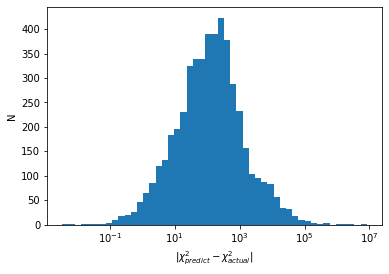

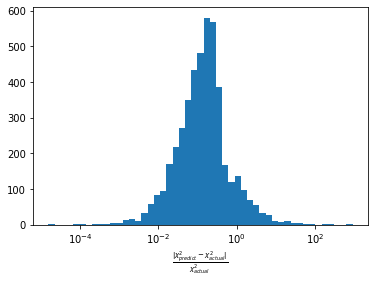

In [11]:
plt.hist(chi_squared_err, bins=np.logspace(np.log10(np.amin(chi_squared_err[(chi_squared_err != 0)])), np.log10(np.amax(chi_squared_err)), 50))
plt.xlabel(r"$|\chi_{predict}^2 - \chi_{actual}^2|$")
plt.ylabel("N")
plt.xscale("log")

chi_squared_valid = chi_squared_actual[(chi_squared_actual >= 0)]
print(len(chi_squared_actual) - len(chi_squared_valid))
chi_squared_rel_err = chi_squared_err / chi_squared_actual
num_bad = len(chi_squared_rel_err[(chi_squared_rel_err >= 0.01)])
print("{:0d} ({:0.2f})% of matrices have chi squared errors worse than 1%!".format(num_bad, 100.*num_bad/N_test))

chi_squared_rel_err_1 = chi_squared_rel_err[(chi_squared_rel_err >= 0)]
plt.figure()
plt.hist(chi_squared_rel_err_1, bins=np.logspace(np.log10(np.amin(chi_squared_rel_err_1)), np.log10(np.amax(chi_squared_rel_err_1)), 50))
plt.xlabel(r"$\frac{|\chi_{predict}^2 - \chi_{actual}^2|}{\chi_{actual}^2}$")
plt.xscale("log")

In [12]:
def make_heatmap(x, y, z, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            z_new[j,i] = np.mean(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
    
    return x_new, y_new, z_new

def make_diagonal(x, y, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.zeros(bins)
    for i in range(bins):
        y_new[i] = np.mean(y[(x >= x_new[i]) & (x <= x_new[i+1])])
    return x_new[:bins], y_new

def plot_chi_squared_heatmap(params, chi_squared, label, extents):
    names = ['H0', 'omch2', 'ombh2', "As", "b1", "b2", "chi_squared"]
    labels= [r"$H_0$", r'$\omega_{cdm}$', r'$\omega_b$', r"$A_s$", "$b1$", "$b2$", label]

    fig, axs = plt.subplots(6,6, figsize=(14,14))
    for i in range(6):
        for j in range(6):
            if i < j:
                axs[i][j].axis("off")
                continue
            if i == j:
                x, y = make_diagonal(params[:,j], chi_squared, 30)
                axs[i][j].axhline(0, color="red")
                axs[i][j].plot(x, y)
            else:
                #X, Y, Z = make_heatmap(params[:,j], params[:,i], chi_squared, 30)
                #img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap="coolwarm", 
                #                     norm=colors.LogNorm(vmin=extents[0], vmax=extents[1]))
                #axs[i,j].set_xlim(X[0] - (X[-1] - X[0]) * 0.05, X[-1] + (X[-1] - X[0]) * 0.05)
                #axs[i,j].set_ylim(Y[0] - (Y[-1] - Y[0]) * 0.05, Y[-1] + (Y[-1] - Y[0]) * 0.05)
                img = axs[i][j].scatter(params[:,j], params[:,i], c=chi_squared, s=1, alpha=0.8, cmap="coolwarm",
                                        norm=colors.LogNorm(vmin=extents[0], vmax=extents[1]))
            if i != j: axs[i][j].axhline(params_fid[i], linestyle="--", c="black")
            axs[i][j].axvline(params_fid[j], linestyle="--", c="black")
            if i == 5: axs[i][j].set_xlabel(labels[j])
            if j == 0 and i != 0: axs[i][j].set_ylabel(labels[i])
            if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
            elif j != 0 and i == 5: axs[i][j].yaxis.set_ticklabels([])
            elif j != 0 and i != 5:
                axs[i][j].xaxis.set_ticklabels([])
                axs[i][j].yaxis.set_ticklabels([])

    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_label(labels[-1] ,size=20)
    cbar.ax.tick_params(labelsize=15) 
    plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout(

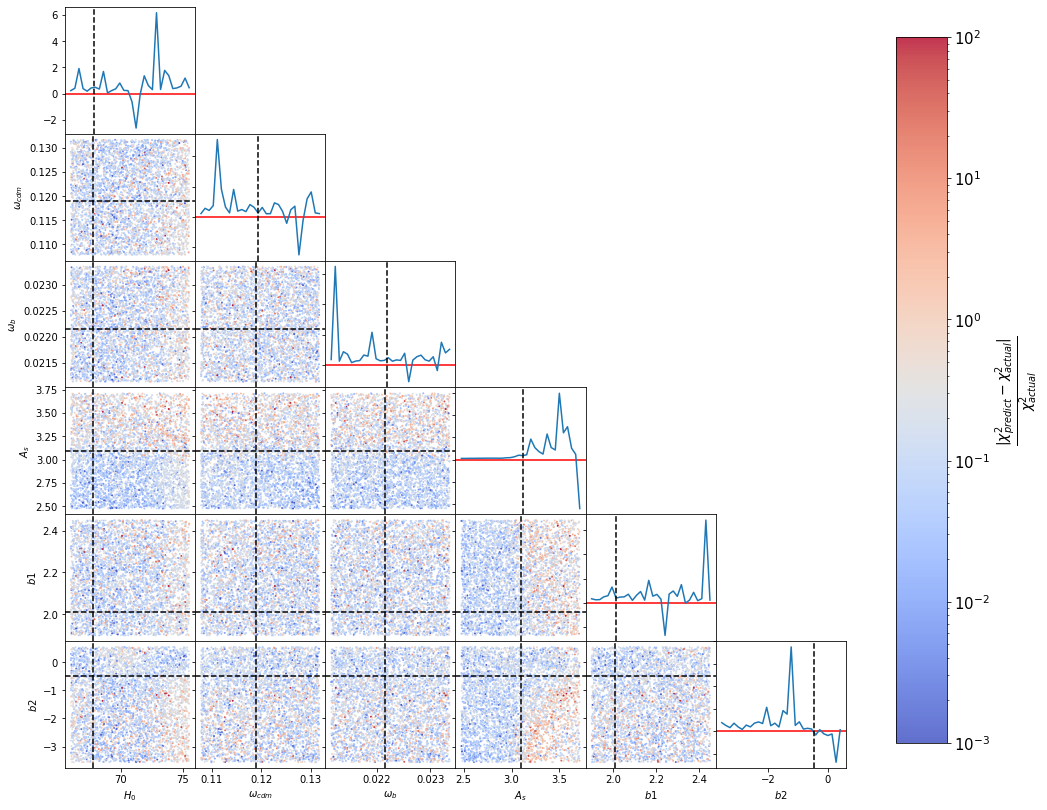

In [13]:
params = test_data[:][0].detach().numpy()
plot_chi_squared_heatmap(params, chi_squared_rel_err, r"$\frac{|\chi_{predict}^2 - \chi_{actual}^2|}{\chi_{actual}^2}$", [1e-3, 1e2])

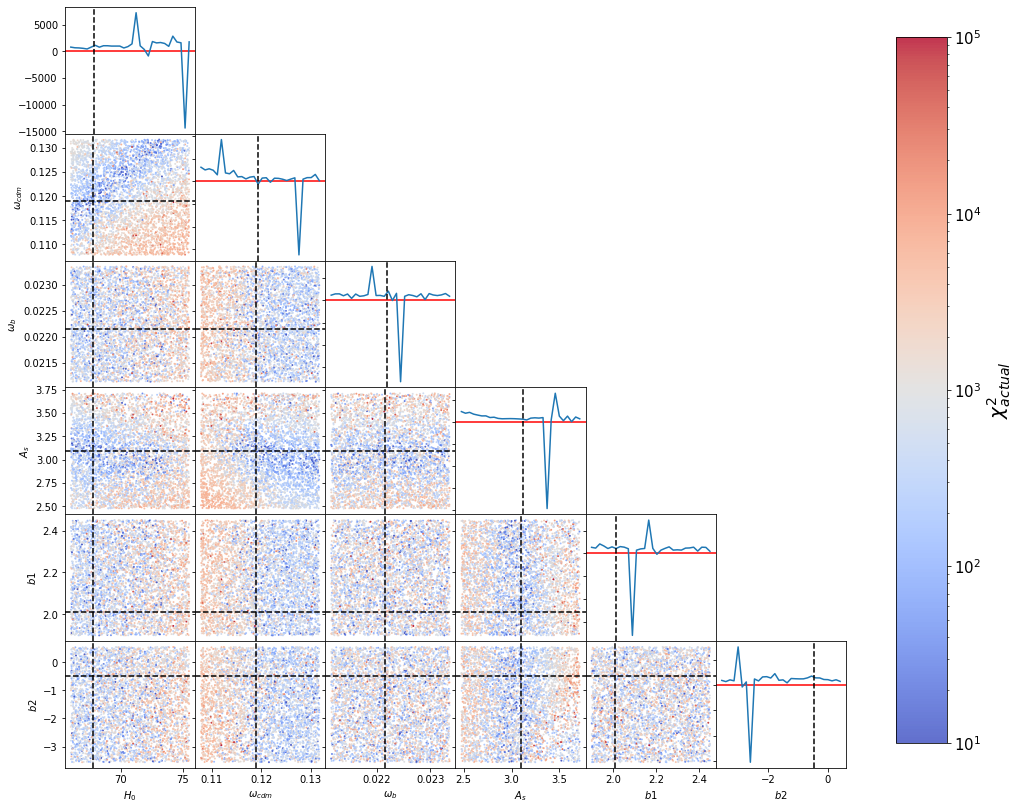

In [14]:
plot_chi_squared_heatmap(params, chi_squared_actual, r"$\chi_{actual}^2$", [1e1, 1e5])

In [15]:
# do a PCA on the whole training set, treating each covariance matrix as a single realization
data_predict = np.zeros((N_test, 100*100))
data_actual  = np.zeros((N_test, 100*100))

for i in tqdm(range(N_test)):
    params = test_data[i][0]; C_actual = test_data[i][1].view(100,100)
    C_predict = decoder(net_2(params).view(1,10)).view(100, 100)
    C_predict = CovNet.symmetric_exp(C_predict).detach().numpy()
    C_actual = C_actual.detach().numpy()
    
    data_predict[i] = C_predict.flatten()
    data_actual[i] = C_actual.flatten()

pca = PCA(n_components = 100)
# find the principal axes (basis vectors) of the testing set
pca.fit(data_actual)
# now project both the testing set and the prediced matrices set onto those basis vectors
components_predict = pca.transform(data_predict)
components_actual = pca.transform(data_actual)

100%|██████████████████████████████████████| 4950/4950 [00:13<00:00, 359.96it/s]


0.9999999996755629
[4.63690098e+09 2.29103749e+09 1.74279447e+09 8.50234354e+08
 7.30031561e+08 6.94182790e+08 7.57624336e+08 3.09854731e+08
 2.78298731e+08 2.43985756e+08]


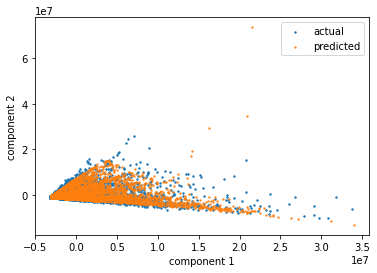

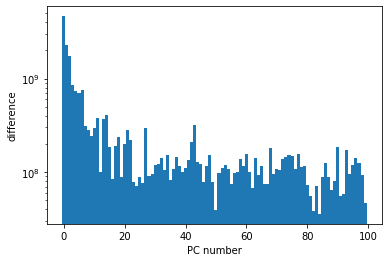

In [16]:
print(np.sum(pca.explained_variance_ratio_[:100]))
PCA_diff = np.sum(abs(components_predict - components_actual), axis=0)
print(PCA_diff[:10])

plt.scatter(components_actual[:, 0], components_actual[:, 1], s=2, label="actual")
plt.scatter(components_predict[:, 0], components_predict[:, 1], s=2, alpha=0.8, label="predicted")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.legend()

plt.figure()
plt.bar(range(100), PCA_diff[:100], width=1)
plt.xlabel("PC number")
plt.ylabel("difference")
plt.yscale("log")

final training loss: tensor(1364.4938)


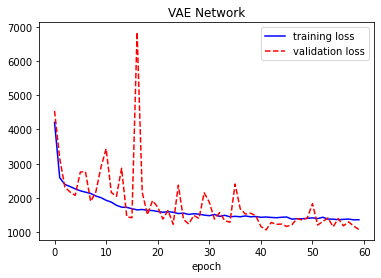

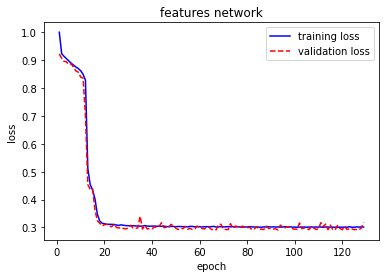

In [24]:
# visualize the training and validation loss
train_loss = torch.load(net_dir+"train_loss.dat")
valid_loss = torch.load(net_dir+"valid_loss.dat")
train_loss_f = torch.load(net_dir+"train_loss-features.dat")
valid_loss_f = torch.load(net_dir+"valid_loss-features.dat")

print("final training loss:", train_loss[-1])

epoch = range(len(train_loss))
plt.title("VAE Network")
plt.plot(epoch, train_loss, color="blue", label="training loss")
plt.plot(epoch, valid_loss, color="red", ls="--", label="validation loss")
plt.xlabel("epoch")
#plt.ylabel("loss")
#plt.ylim(800, 4000)
#plt.yscale("log")
plt.legend()

epoch_f = range(len(train_loss_f))
plt.figure()
plt.title("features network")
plt.plot(epoch_f[1:], train_loss_f[1:], color="blue", label="training loss")
plt.plot(epoch_f[1:], valid_loss_f[1:], color="red", ls="--", label="validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.yscale("log")
plt.legend(
)

In [18]:
# try to visualize the latent feature space
features = torch.zeros(N, 10, device=CovNet.try_gpu())
t1 = time.time()
for (i, batch) in enumerate(test_loader):
    params = batch[0]; matrix = batch[1]
    z, mu, log_var = encoder(matrix.view(1, 100, 100))
    features[i] = z
    
features = features.to("cpu").detach().numpy()
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))

Done!, took 0 minutes 10.47 seconds


[6.2667100e+03 3.2664998e-03 9.1217278e-04 9.2341174e+02 4.7223160e+04
 1.6231767e+04 2.7066994e+04 1.2154142e+03 4.9374062e+04 6.7605816e-02]


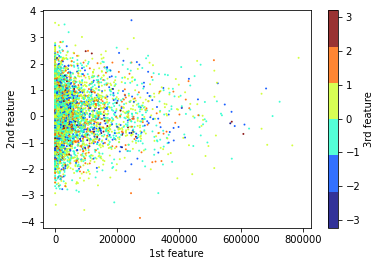

In [19]:
N_colors = 6 # <- number of colors
base = plt.cm.get_cmap("jet")
color_list = base(np.linspace(0, 1, N_colors))
cmap_name = base.name + str(N)
cmap = base.from_list(cmap_name, color_list, N_colors)

print(np.mean(features, axis=0))
f1 = 0; f2 = 1; f3 = 2
plt.scatter(features[:,f1], features[:,f2], cmap=cmap, c=features[:,f3], alpha=0.8, s=1)
plt.xlabel("1st feature")
plt.ylabel("2nd feature")
cbar = plt.colorbar()
cbar.set_label("3rd feature")

### Tests on individual matrices

Indexes: 2022 3906


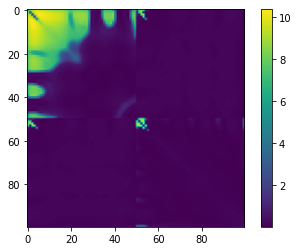

In [20]:
# Let's first confirm that seperate parameter imputs give different outputs
# if the resulting plot is all zeros, that may suggest posterior collapse of the network
idx1 = np.random.randint(0, N_test); idx2 = np.random.randint(0, N_test)
params1 = test_data[idx1][0]; params2 = test_data[idx2][0]
cov_actual1 = test_data[idx1][1]; cov_actual2 = test_data[idx2][1]

features = net_2(params1); cov_predict1 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()
features = net_2(params2); cov_predict2 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()

# If this plot has mostly 0's everywhere than the network isn't distiguishing between cosmologies!
print("Indexes:", idx1, idx2)
plt.imshow(abs(cov_predict1 - cov_predict2))
cbar = plt.colorbar()

loss =  1227.5107421875
reduction = 733.092, KL Divergence = 494.419
sample 1, params: tensor([ 7.1195e+01,  1.2063e-01,  2.2936e-02,  3.5042e+00,  2.1458e+00,
        -2.1640e+00])


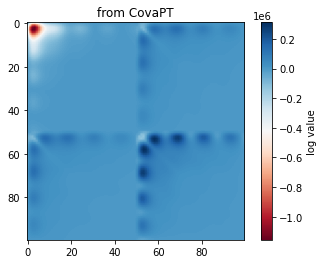

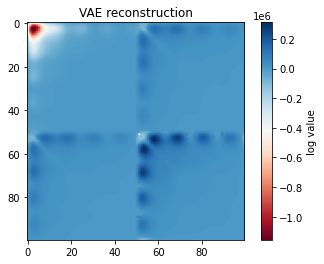

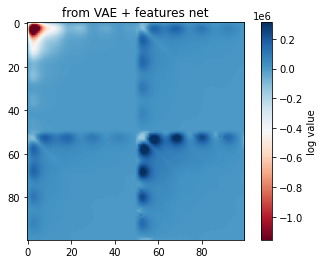

In [21]:
# Let's do some more detailed analysis on a random matrix from the test set
#idx = np.random.randint(0, N_test)
idx = 1
params = test_data[idx][0]
# matrix from CovaPT
cov_actual = CovNet.symmetric_log(test_data[idx][1])
# matrix from VAE reconstruction
cov_VAE, mu, log_var = net(cov_actual.view(1,100,100)); cov_VAE = cov_VAE.view(100,100)
# matrix from parameters -> features and features -> matrix
features = net_2(params); cov_predict = decoder(features.view(1,10)).view(100, 100)

RLoss = F.l1_loss(cov_VAE, cov_actual, reduction="sum")
KLD = 0.5 * torch.sum(log_var.exp() - log_var - 1 + mu.pow(2))

print("loss = ", CovNet.VAE_loss(cov_VAE, cov_actual, mu, log_var).item())
print("reduction = {:0.3f}, KL Divergence = {:0.3f}".format(RLoss, KLD)) 
print("sample " + str(idx) + ", params:", params)
cov_actual = CovNet.symmetric_exp(cov_actual)
cov_VAE = CovNet.symmetric_exp(cov_VAE)
cov_predict = CovNet.symmetric_exp(cov_predict)

cov_VAE = cov_VAE.to("cpu").detach(); cov_predict = cov_predict.to("cpu").detach(); cov_actual = cov_actual.to("cpu").detach();

plt.figure()
plt.title("from CovaPT")
plt.imshow(cov_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("VAE reconstruction")
plt.imshow(cov_VAE, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("from VAE + features net")
plt.imshow(cov_predict, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

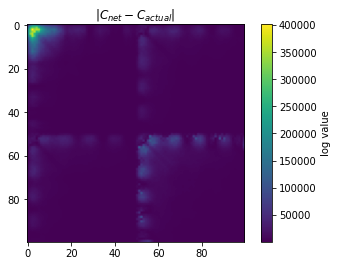

In [22]:
# Visualize the difference between generated and actual matrix
C_residual = abs(cov_predict - cov_actual)
plt.title(r"$|C_{net} - C_{actual}|$")
plt.imshow(C_residual)
cbar = plt.colorbar()
cbar.set_label("log value")

In [23]:
# Test for positive definite-ness
model_vector, C_G = gaussian_covariance(params.detach().numpy(), idx, int(N*0.9))
C = C_G + cov_predict.detach().numpy()

pos_diag = True
for i in range(C.shape[0]):
    if C[i,i] <= 0:
        pos_diag = False
print("diagonal is all positive:", pos_diag)

try:
    np.testing.assert_allclose(C, C.T, err_msg="covariance must match transpose")
    print("matrix is symmetric: True")
except AssertionError:
    print("matrix is symmetric: False")

L = np.linalg.cholesky(C)
    
eigen, v = np.linalg.eig(C)
sv = np.linalg.svd(C, compute_uv=False)
print("eigenvalues all positive:", np.all(eigen >= 0.))

plt.imshow(C, cmap="RdBu")
plt.colorbar()

plt.figure()
plt.plot(range(len(eigen)), eigen)
plt.plot(range(len(sv)), sv)
plt.yscale("log")

diagonal is all positive: True
matrix is symmetric: True


LinAlgError: Matrix is not positive definite

In [ ]:
cov_predict2 = cov_predict.to(CovNet.try_gpu())
cov_sym = (CovNet.symmetric_exp(cov_predict2) + CovNet.symmetric_exp(torch.t(cov_predict2)))
cov_asym = (CovNet.symmetric_exp(cov_predict2) - CovNet.symmetric_exp(torch.t(cov_predict2)))
symmetric_val = torch.linalg.norm(cov_asym, 2) / torch.linalg.norm(cov_sym, 2)
print(symmetric_val)

plt.figure()
plt.title(r"$C - C^T$")
#plt.imshow(cov_test2 - cov_test2.T, cmap="RdBu")
plt.imshow(cov_asym.cpu(), cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("symlog value")

## Extra tests for debugging

In [ ]:
# non_definete_SSC, non_definete_G = [], []
# avg_bad_SSC, avg_bad_G = 0., 0.
# if len(non_definete) != 0:
#     for i in tqdm(range(len(non_definete))):
#         idx = non_definete[i]
#         params = test_data[idx][0]; C_NG_actual = test_data[idx][1].detach().numpy()
#         #features = net_2(params); C_NG_predict = decoder(features.view(1,10))
#         #C_NG_predict = CovNet.symmetric_exp(C_NG_predict)

#         with io.capture_output() as captured:
#             model_vector, C_G = gaussian_covariance(params.detach().numpy(), idx, int(N*0.9))
#         C_SSC = CovaPT.get_non_gaussian_covariance(params.detach().numpy())
        
#         eigen, v = np.linalg.eig(C_G + C_NG_actual)
#         if np.all(eigen >= 0.) == False:
#             non_definete_G.append(i)
#             avg_bad_G += len(eigen[(eigen < 0)])
#         eigen, v = np.linalg.eig(C_G + C_SSC)
#         if np.all(eigen >= 0.) == False:
#             non_definete_SSC.append(i)
#             avg_bad_SSC += len(eigen[(eigen < 0)])

#     if len(non_definete_G) != 0:
#         print(len(non_definete_G), "Full Matrices don't have all positive eigenvalues, avg number of bad eigenvalues:", avg_bad_G / len(non_definete_G))

#     if len(non_definete_SSC) != 0:
#         print(len(non_definete_SSC), "SSC Matrices don't have all positive eigenvalues, avg number of bad eigenvalues:", avg_bad_SSC / len(non_definete_SSC))

In [ ]:
params_bad = torch.tensor([74.65041619539261, 0.1152447252368927, 0.0228745732113719, 3.696852154016495, 1.9854176259040832,-2.1415713782310486])
features = net_2(params_bad); C_bad = decoder(features.view(1,10)).view(100, 100)
C_bad = CovNet.corr_to_cov(C_bad).detach().numpy()

try:
    L = np.linalg.cholesky(C_bad)
except np.linalg.LinAlgError as err:
    print("Covariance matrix is NOT positive-definite!")

eigen, v = np.linalg.eig(C_bad)
print(len(eigen[(eigen < 0)]), eigen)
plt.plot(range(100), eigen)

In [ ]:
# test to see what outputs from the training / validation sets looks like
# I'm only loading in a subset of the whole training set to save memory / time
t1 = time.time()
train_data = MatrixDataset(training_dir, int(N*0.1), 0, train_log, train_correlation, train_cholesky)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

In [ ]:
idx = np.random.randint(0, N*0.1)
params = train_data[idx][0]
# matrix from CovaPT
cov_actual = train_data[idx][1]

cov_VAE, mu, log_var = net(cov_actual.view(1,100,100)); cov_VAE = cov_VAE.view(100,100)
# matrix from parameters -> features and features -> matrix
features = net_2(params); cov_predict = decoder(features.view(1,10)).view(100, 100)

RLoss = F.l1_loss(cov_VAE, cov_actual, reduction="sum")
KLD = 0.5 * torch.sum(log_var.exp() - log_var - 1 + mu.pow(2))

print("loss = ", VAE_loss(cov_VAE, cov_actual, mu, log_var).item())
print("rediction = {:0.3f}, KL Divergence = {:0.3f}".format(RLoss, KLD)) 
print("sample " + str(idx) + ", params:", params)
cov_VAE = cov_VAE.to("cpu").detach(); cov_predict = cov_predict.to("cpu").detach(); cov_actual = cov_actual.to("cpu").detach();

plt.figure()
plt.title("from CovaPT")
plt.imshow(cov_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("VAE reconstruction")
plt.imshow(cov_VAE, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("from VAE + features net")
plt.imshow(cov_predict, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

In [ ]:
# Let's first test that seperate parameter imputs give different outputs
idx1 = np.random.randint(0, N*0.1); idx2 = np.random.randint(0, N*0.1)
params1 = train_data[idx1][0]; params2 = train_data[idx2][0]
cov_actual1 = train_data[idx1][1]; cov_actual2 = train_data[idx2][1]

features = net_2(params1); cov_predict1 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()
features = net_2(params2); cov_predict2 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()

# If this plot has mostly 0's everywhere than the network isn't distiguishing between cosmologies!
print("Indexes:", idx1, idx2)
plt.imshow(abs(cov_predict1 - cov_predict2))
cbar = plt.colorbar()